In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
# External dependencies
import os

import cudf  # cuDF is an implementation of Pandas-like Dataframe on GPU
import numpy as np
# import rmm

import nvtabular as nvt

from sklearn.model_selection import train_test_split

In [3]:
INPUT_DATA_DIR = os.environ.get(
    "INPUT_DATA_DIR", os.path.expanduser("./data/")
)

## Movie Feature Engineering

In [4]:
raw_movie_features = cudf.read_parquet(os.path.join(INPUT_DATA_DIR, "raw_movie_features.parquet"))
raw_movie_features.head()

,movie_id,genres,tags_unique,tags_nunique
0,128721,[Drama],"[emigration, prostitute]",2
1,128740,[Documentary],[adoption],1
2,128723,[Drama],[biography],1
3,128762,"[Drama, Thriller]","[Berlinale, bourgeoisie, foreigner, holiday, l...",10
4,128780,[(no genres listed)],"[bank robbery, car chase, fishing, johann seba...",8


In [5]:
movie_features_ds = nvt.Dataset(raw_movie_features)

In [6]:
cat_features = ["tags_unique", "movie_id", "genres"] >> nvt.ops.Categorify(dtype=np.int32)

In [7]:
cont_features = nvt.ColumnGroup([])
discrete_features = nvt.ColumnGroup(["tags_nunique"]) >> nvt.ops.FillMissing()

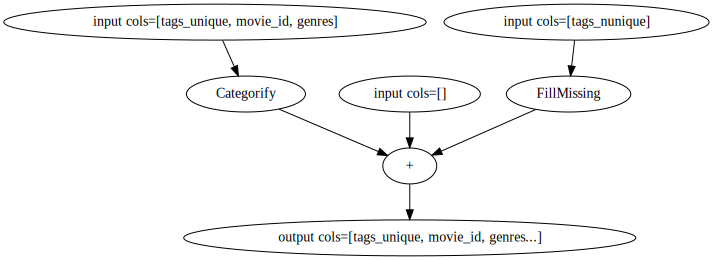

In [8]:
output = cat_features + cont_features + discrete_features
(output).graph

In [9]:
workflow = nvt.Workflow(output)

In [10]:
%%time
workflow.fit(movie_features_ds)

CPU times: user 729 ms, sys: 34.1 ms, total: 763 ms
Wall time: 764 ms


In [11]:
%time
movie_features = workflow.transform(movie_features_ds)

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 3.58 µs


In [12]:
workflow.save(os.path.join(INPUT_DATA_DIR, "movie_features_workflow"))

In [13]:
movie_features.head()

,tags_unique,movie_id,genres,tags_nunique
0,"[40345, 59079]",27265,[9],2
1,[28414],27273,[8],1
2,[32292],27266,[9],1
3,"[3365, 33048, 43053, 46467, 50807, 51310, 5739...",27282,"[9, 18]",10
4,"[31336, 34155, 42699, 48919, 48957, 51656, 602...",27290,[1],8


In [14]:
movie_features_df = movie_features.to_ddf().compute()

In [15]:
import datetime

timestamp = datetime.datetime.now()
movie_features_df["datetime"] = timestamp
movie_features_df["created"] = timestamp

In [16]:
movie_features_df

,tags_unique,movie_id,genres,tags_nunique,datetime,created
0,"[40345, 59079]",27265,[9],2,2021-07-06 19:32:27.902010,2021-07-06 19:32:27.902010
1,[28414],27273,[8],1,2021-07-06 19:32:27.902010,2021-07-06 19:32:27.902010
2,[32292],27266,[9],1,2021-07-06 19:32:27.902010,2021-07-06 19:32:27.902010
3,"[3365, 33048, 43053, 46467, 50807, 51310, 5739...",27282,"[9, 18]",10,2021-07-06 19:32:27.902010,2021-07-06 19:32:27.902010
4,"[31336, 34155, 42699, 48919, 48957, 51656, 602...",27290,[1],8,2021-07-06 19:32:27.902010,2021-07-06 19:32:27.902010
...,...,...,...,...,...,...
62418,[],40828,"[12, 18]",0,2021-07-06 19:32:27.902010,2021-07-06 19:32:27.902010
62419,[],40805,[1],0,2021-07-06 19:32:27.902010,2021-07-06 19:32:27.902010
62420,[],40821,[6],0,2021-07-06 19:32:27.902010,2021-07-06 19:32:27.902010
62421,[],40814,[1],0,2021-07-06 19:32:27.902010,2021-07-06 19:32:27.902010


In [17]:
movie_features_df.to_parquet(os.path.join(INPUT_DATA_DIR, "movie_features.parquet"))